In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c rdkit rdkit

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...
Channels:
 - rdkit
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb9d3cd8_2          18 KB  conda-forge
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    cairo-1.18.4               |       h3394656_0         955 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    chardet-5.2.0        

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

In [3]:
Path="/content/sample_data"
dataset_file = f"{Path}/dataset.csv"

In [4]:
data = pd.read_csv(dataset_file)
data.head(5)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CWYBNSVSYKQGJB-UHFFFAOYNA-N,71541095,6532,A,6.85387,pubchem,727355,9606,SLC6A4,4061,ClC=1C=C(C2CCCCNC2)C=CC1Cl
1,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6532,A,6.37000,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl
2,FQDRMHHCWZAXJM-UHFFFAOYNA-N,125558,25553,A,9.98297,pubchem,205028,10116,SLC6A4,4061,O1C=2C=C3CC(N)CC3=CC2OC1
3,QRAWNNQNLQPNIZ-UHFFFAOYNA-N,CHEMBL205229,6532,A,7.54000,chembl20,950695,9606,SLC6A4,4061,N1C=C(CCN)C2=C1C(=CC=C2)F
4,HCFHWXDIZOAUTQ-UHFFFAOYNA-N,CHEMBL6376,25553,A,6.11000,chembl20,201505,10116,SLC6A4,4061,C1(=CC=2OCOC2C=C1C)CC(N)C


In [5]:
PandasTools.AddMoleculeColumnToFrame(data,'SMILES','Molecule')

In [6]:
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,Molecule
0,CWYBNSVSYKQGJB-UHFFFAOYNA-N,71541095,6532,A,6.85387,pubchem,727355,9606,SLC6A4,4061,ClC=1C=C(C2CCCCNC2)C=CC1Cl,<rdkit.Chem.rdchem.Mol object at 0x7a61d71d5a80>
1,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6532,A,6.37000,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7a61d71d59a0>
2,FQDRMHHCWZAXJM-UHFFFAOYNA-N,125558,25553,A,9.98297,pubchem,205028,10116,SLC6A4,4061,O1C=2C=C3CC(N)CC3=CC2OC1,<rdkit.Chem.rdchem.Mol object at 0x7a61d71d5af0>
3,QRAWNNQNLQPNIZ-UHFFFAOYNA-N,CHEMBL205229,6532,A,7.54000,chembl20,950695,9606,SLC6A4,4061,N1C=C(CCN)C2=C1C(=CC=C2)F,<rdkit.Chem.rdchem.Mol object at 0x7a61d71d5b60>
4,HCFHWXDIZOAUTQ-UHFFFAOYNA-N,CHEMBL6376,25553,A,6.11000,chembl20,201505,10116,SLC6A4,4061,C1(=CC=2OCOC2C=C1C)CC(N)C,<rdkit.Chem.rdchem.Mol object at 0x7a61d71d67a0>


In [7]:
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

fp = mol2fp(Chem.MolFromSmiles(data.loc[1,"SMILES"]))

[18:27:44] DEPRECATION WARNING: please use MorganGenerator


In [8]:
fp

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [9]:
len(fp)

4096

In [10]:
data.loc[1,"SMILES"]

'C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl'

In [11]:
fp.reshape((64,-1))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [12]:
4096/64

64.0

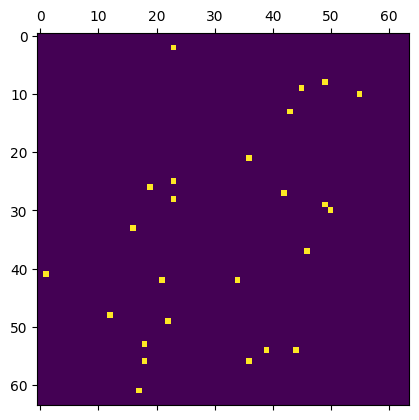

In [13]:
plt.matshow(fp.reshape((64,-1)) > 0)

In [14]:
data["FPs"] = data.Molecule.apply(mol2fp)

Výstupní stream byl oříznut na posledních 5000 řádků.
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[18:28:00] DEPRECATION WARNING: please use MorganGenerator
[1

In [15]:
data["FPs"].head(5)

,FPs
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
X = np.stack(data.FPs.values)

In [17]:
data.FPs.values

array([array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
       array([0, 0, 0, ..., 0, 0, 0], dtype=int8), ...,
       array([0, 2, 0, ..., 0, 0, 0], dtype=int8),
       array([0, 2, 0, ..., 0, 0, 0], dtype=int8),
       array([0, 2, 0, ..., 0, 0, 0], dtype=int8)], dtype=object)

In [18]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int8)

In [19]:
y = data.pXC50.values.reshape((-1,1))

In [20]:
y

array([[6.85387],
       [6.37   ],
       [9.98297],
       ...,
       [6.60206],
       [6.8    ],
       [6.14   ]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [22]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [23]:
# SVR had best results
model = SVR(kernel='rbf')
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R2 Score: 0.6205
Mean Squared Error: 0.3740


In [24]:
y_validation

array([[ 0.98149849],
       [ 0.10682453],
       [ 0.16821306],
       [ 1.44925375],
       [-0.83578527],
       [-0.58951784],
       [-1.14149656],
       [ 0.45052045],
       [-0.10547497],
       [-1.31982814],
       [ 0.66729522],
       [ 1.07491027],
       [ 1.87315641],
       [ 1.96052191],
       [ 1.17856338],
       [ 0.08984057],
       [-0.52713576],
       [-0.40269428],
       [ 0.41253582],
       [-0.3059961 ],
       [-0.85276923],
       [-0.4366622 ],
       [ 0.57388344],
       [-0.01150272],
       [ 0.60005573],
       [-1.66777854],
       [-1.26781476],
       [-1.26038428],
       [ 1.51649324],
       [-0.01206319],
       [-0.82729329],
       [-0.77634141],
       [-0.93768903],
       [-0.02865652],
       [ 0.58264717],
       [-0.09698299],
       [ 0.70975513],
       [ 0.72673909],
       [ 1.00697443],
       [-0.72410724],
       [-1.3368121 ],
       [-1.14612469],
       [ 0.00649179],
       [ 1.51649324],
       [ 0.74372305],
       [ 1

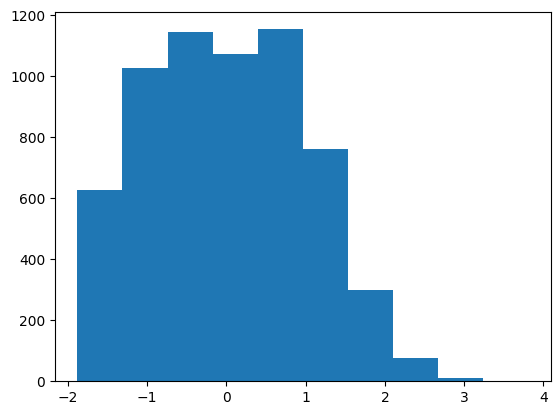

In [25]:
plt.hist(y_train)
plt.show()

In [26]:
X_train.shape

(6179, 4096)

In [27]:
7700*0.85

6545.0

In [28]:
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(6179, 222)

In [29]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If you don't have a GPU, buy a graphics card. I have for a long time used a 1060 GTX, which is not that expensive anymore.
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cpu


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
device

device(type='cpu')

In [32]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [33]:
train_dataset

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [35]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc15 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln15 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc15(out)
        out = self.ln15(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out


In [49]:
#Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024      # The size of the hidden layer
dropout_rate = 0.5     # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.0005  # The learning rate for the optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)

In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 80
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa

        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))

Epoch:   0 Training loss: 1.41 Validation loss: 1.07
Epoch:  10 Training loss: 0.42 Validation loss: 0.50
Epoch:  20 Training loss: 0.27 Validation loss: 0.50
Epoch:  30 Training loss: 0.24 Validation loss: 0.46
Epoch:  40 Training loss: 0.21 Validation loss: 0.44
Epoch:  50 Training loss: 0.19 Validation loss: 0.43
Epoch:  60 Training loss: 0.18 Validation loss: 0.44
Epoch:  70 Training loss: 0.17 Validation loss: 0.43


In [52]:
model.eval() #Switch to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [53]:
torch.mean(( y_train - y_pred_train )**2).item()

0.10378683358430862

In [54]:
torch.mean(( y_validation - y_pred_validation )**2).item()

0.3961358964443207

In [55]:
torch.mean(( y_test - y_pred_test )**2).item()

0.3327372968196869

In [56]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

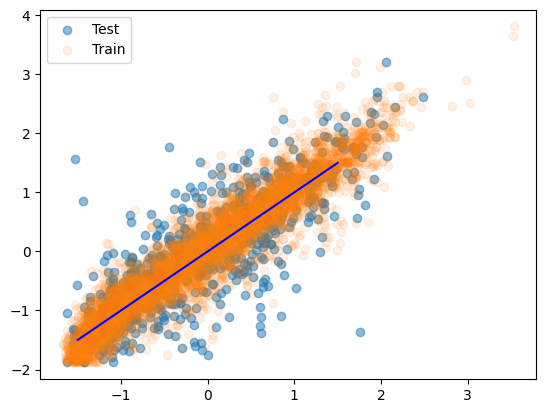

In [57]:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

In [58]:
def predict_smiles(smiles):
    fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pXC50[0][0]

In [59]:
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

[18:50:44] DEPRECATION WARNING: please use MorganGenerator


np.float32(8.475982)

In [60]:
model

Net(
  (fc1): Linear(in_features=222, out_features=1024, bias=True)
  (fc15): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln15): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
)